#### Importing the necessary library to work with data and loading the dataset

In this step, we are importing the **Pandas** library, which is used for data manipulation and analysis. We then read in the dataset from a CSV file that contains information about customers in a bank, including various attributes like age, job type, marital status, and more. The dataset is loaded into a variable called `df`.


In [28]:
import pandas as pd
df = pd.read_csv("../data/raw/bank/bank-full.csv", sep=";")

#### Displaying the first few rows of the dataset to get an overview of the data

Here, we are using the `.head()` method to show the first five rows of the dataset. This gives us a sneak peek at the structure of the data, such as the columns and the first few entries, so we can understand what we’re working with.


In [29]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


#### Checking the dataset’s structure

Now, we are using the `.info()` method to examine the structure of the dataset in more detail. This method gives us information about the number of rows and columns, the types of data in each column (e.g., numbers or text), and whether any columns have missing values. It helps us understand the data better and determine if we need to clean it.


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


#### Checking if there are any duplicate rows in the dataset

Here, we are checking for duplicate rows using the `.duplicated()` method. If any rows are repeated, they might introduce unnecessary bias or errors into our analysis, so we need to identify and deal with them.


In [31]:
print(df.duplicated().sum())

0


#### Identifying columns with "unknown" values

The dataset has some entries labeled as "unknown" in various columns. We are now checking how many "unknown" values there are in each column. These values might represent missing data or placeholders and need to be addressed before further analysis.


In [32]:
unknown_counts = (df == "unknown").sum()
unknown_counts

age              0
job            288
marital          0
education     1857
default          0
balance          0
housing          0
loan             0
contact      13020
day              0
month            0
duration         0
campaign         0
pdays            0
previous         0
poutcome     36959
y                0
dtype: int64

# Balance


#### Handling outliers in the 'balance' column and estimating propensity scores

In this step, we handle outliers in the `balance` column by clipping values at the 1st and 99th percentiles. This prevents extreme values from skewing the analysis. Afterward, we define a new treatment variable based on whether the balance is higher or lower than the median of the clipped balance.

We then use logistic regression to estimate propensity scores based on the features, which will later be used for matching treated and control samples in the dataset.


In [33]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Load dataset
# df = pd.read_csv("your_dataset.csv")

# --- Handle outliers in 'balance' ---
# Clip balance at the 1st and 99th percentile
lower_bound = df['balance'].quantile(0.01)
upper_bound = df['balance'].quantile(0.99)
df['balance_clipped'] = df['balance'].clip(lower=lower_bound, upper=upper_bound)

# Use clipped balance to define treatment
median_balance = df['balance_clipped'].median()
df['treatment'] = (df['balance_clipped'] >= median_balance).astype(int)

# Define features for propensity score estimation (excluding target 'y')
X = df.drop(columns=['y', 'treatment', 'balance', 'balance_clipped'])
y = df['treatment']

# Convert categorical variables to dummies
X = pd.get_dummies(X, drop_first=True)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit logistic regression for propensity scores
logreg = LogisticRegression(solver='saga', max_iter=1000)
logreg.fit(X_scaled, y)
df['propensity_score'] = logreg.predict_proba(X_scaled)[:, 1]


    balance  treatment  propensity_score
0      2143          1          0.581633
3      1506          1          0.484080
9       593          1          0.430160
20      723          1          0.286103
21      779          1          0.564425


#### Matching treated and control samples based on propensity scores

Here, we apply Propensity Score Matching (PSM) to pair treated and control samples based on their propensity scores. We use a caliper (0.05 in this case) to limit the difference between the propensity scores of matched pairs. After matching, we output the final balanced dataset, which consists of both treated and control samples that are comparable in terms of their propensity scores.


In [58]:
# --- Propensity Score Matching ---
caliper = 0.05

def match_sample(df):
    treated = df[df['treatment'] == 1]
    control = df[df['treatment'] == 0]
    matched_control = []

    for _, row in treated.iterrows():
        potential_matches = control[abs(control['propensity_score'] - row['propensity_score']) <= caliper]
        if not potential_matches.empty:
            match = potential_matches.sample(1)
            matched_control.append(match)
            control = control.drop(match.index)

    matched_control = pd.concat(matched_control)
    balanced_df = pd.concat([treated, matched_control])
    return balanced_df

balanced_df = match_sample(df)

# Output final dataset
print(balanced_df[['balance', 'treatment', 'propensity_score']].head())

    balance  treatment  propensity_score
0      2143          1          0.116512
3      1506          1          0.073455
9       593          1          0.149584
20      723          1          0.176293
21      779          1          0.136159


In [34]:
# Winsorize to limit outliers in balance
df['balance_winsorized'] = df['balance'].clip(
    lower=df['balance'].quantile(0.01),
    upper=df['balance'].quantile(0.99)
)


/var/folders/l4/t9jrg3810fj7mltqzxyw19sh0000gn/T/ipykernel_45269/2314164844.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(balanced_df[balanced_df['treatment'] == 1]['propensity_score'], label="Treated", shade=True)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/l4/t9jrg3810fj7mltqzxyw19sh0000gn/T/ipykernel_45269/2314164844.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(balanced_df[balanced_df['treatment'] == 0]['propensity_score'], label="Control", shade=True)
/opt/anaconda3/lib/python3.11/site-packages

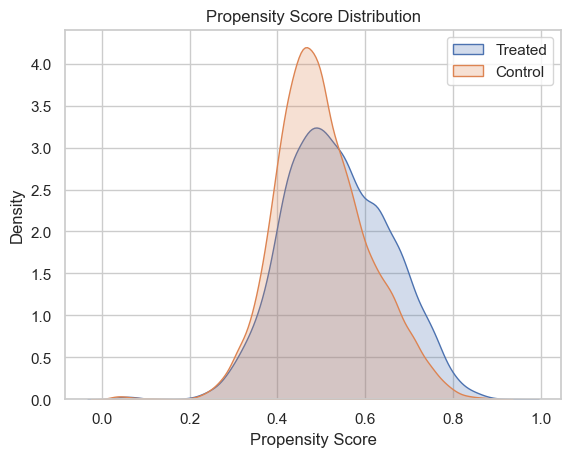

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.kdeplot(balanced_df[balanced_df['treatment'] == 1]['propensity_score'], label="Treated", shade=True)
sns.kdeplot(balanced_df[balanced_df['treatment'] == 0]['propensity_score'], label="Control", shade=True)
plt.xlabel("Propensity Score")
plt.ylabel("Density")
plt.title("Propensity Score Distribution")
plt.legend()
plt.show()


#### Calculating inverse probability weights for each sample

We compute the inverse probability weights, which are used to adjust for any differences between treated and control samples. These weights help to balance the dataset by giving more weight to underrepresented samples in the treatment group.


In [36]:
# Compute inverse probability weights
balanced_df['weights'] = balanced_df['treatment'] / balanced_df['propensity_score'] + (1 - balanced_df['treatment']) / (1 - balanced_df['propensity_score'])

# Check weight distribution
print(balanced_df['weights'].describe())


count    41246.000000
mean         2.052550
std          0.814058
min          1.020850
25%          1.684528
50%          1.929947
75%          2.261134
max         60.972839
Name: weights, dtype: float64


#### Visualizing the original and clipped balance distributions

We visualize the balance distributions before and after clipping. The left plot shows the original balance distribution, which may contain extreme values, while the right plot shows the balance distribution after clipping, where extreme values are removed. This helps to understand the impact of outlier removal on the data.


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


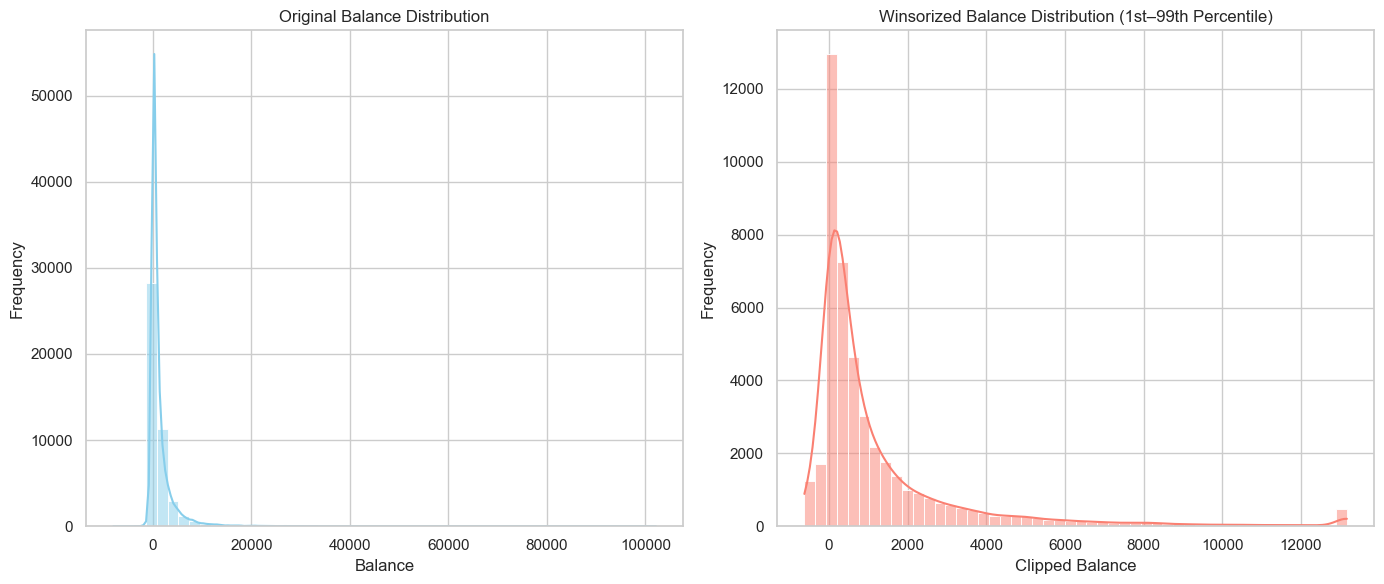

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plot style
sns.set(style="whitegrid")

# Create subplots
plt.figure(figsize=(14, 6))

# Plot original balance distribution
plt.subplot(1, 2, 1)
sns.histplot(df['balance'], bins=50, kde=True, color='skyblue')
plt.title('Original Balance Distribution')
plt.xlabel('Balance')
plt.ylabel('Frequency')

# Plot clipped (Winsorized) balance distribution
plt.subplot(1, 2, 2)
sns.histplot(df['balance_clipped'], bins=50, kde=True, color='salmon')
plt.title('Winsorized Balance Distribution (1st–99th Percentile)')
plt.xlabel('Clipped Balance')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


#### Mapping 'yes' to 1 and 'no' to 0

In this step, we convert the target variable `y` (which indicates whether a customer subscribed to a term deposit) from categorical values ('yes' and 'no') to numeric values (1 for 'yes' and 0 for 'no'). This transformation is necessary for certain machine learning models to work correctly.


In [38]:
# Map 'yes' to 1 and 'no' to 0
balanced_df['y_numeric'] = balanced_df['y'].map({'yes': 1, 'no': 0})


#### Calculating the Average Treatment Effect on the Treated (ATT)

Here, we separate the treated and control groups, which were matched based on their propensity scores. We calculate the average outcome for each group and then compute the Average Treatment Effect on the Treated (ATT), which measures the effect of the treatment on those who actually received it.


In [39]:
# Separate treated and control groups
treated_matched = balanced_df[balanced_df['treatment'] == 1]
control_matched = balanced_df[balanced_df['treatment'] == 0]

# Calculate the average outcome in each group
treated_mean = treated_matched['y_numeric'].mean()
control_mean = control_matched['y_numeric'].mean()

# Calculate ATT
att = treated_mean - control_mean
print(f"ATT (Average Treatment Effect on the Treated): {att:.4f}")


ATT (Average Treatment Effect on the Treated): 0.0433


# Housing


#### Creating a new feature based on housing status

In this step, we create a new binary feature called `housing_treatment`, which indicates whether a customer has a housing loan or not. We map 'yes' to 1 and 'no' to 0 for this new variable.


In [40]:
df['housing_treatment'] = (df['housing'] == 'yes').astype(int)

#### Preparing the data for propensity score estimation

Here, we prepare the features (`X`) and target (`y`) for propensity score estimation. We drop the target variable `y`, treatment variable `housing_treatment`, and balance columns as they are not needed for the modeling. Then, we convert categorical variables into dummy variables to be used in the logistic regression model.


In [41]:
X = df.drop(columns=['y', 'housing', 'housing_treatment'])
y = df['housing_treatment']

In [42]:
X = pd.get_dummies(X, drop_first=True)

#### Standardizing the features for logistic regression

We standardize the features to ensure they are all on the same scale. Standardization is important because logistic regression (and many other machine learning algorithms) performs better when the features are on a similar scale, reducing the influence of features with larger numerical ranges.


In [43]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### Fitting the logistic regression model for propensity scores

In this step, we fit a logistic regression model using the standardized features (`X_scaled`) and the treatment variable (`y`). The model will estimate the propensity scores, which represent the probability of receiving treatment given the covariates. These scores will be used for matching treated and control samples.


In [44]:
logreg = LogisticRegression(solver='saga', max_iter=1000, random_state=42)
logreg.fit(X_scaled, y)
df['propensity_score'] = logreg.predict_proba(X_scaled)[:, 1]

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


#### Propensity score matching function

We define a function to match treated and control samples based on their propensity scores. The function uses a caliper value (0.05) to limit the maximum allowed difference between propensity scores. This ensures that only samples with similar scores are matched together for comparison.


In [45]:
def match_sample(df, caliper=0.05):
    treated = df[df['housing_treatment'] == 1]
    control = df[df['housing_treatment'] == 0]
    matched_control = []

    for _, row in treated.iterrows():
        potential_matches = control[np.abs(control['propensity_score'] - row['propensity_score']) <= caliper]
        if not potential_matches.empty:
            match = potential_matches.sample(1, random_state=42)
            matched_control.append(match)
            control = control.drop(match.index)

    matched_control = pd.concat(matched_control)
    return pd.concat([treated, matched_control])


#### Performing Propensity Score Matching for Housing Treatment

Here, we apply the previously defined matching function to the dataset to match treated and control samples based on their propensity scores. This function creates a balanced dataset where the treated and control groups are comparable in terms of their likelihood to receive the treatment (having a housing loan).


In [46]:
matched_df_housing = match_sample(df.copy())
matched_df_housing['y_numeric'] = matched_df_housing['y'].map({'yes': 1, 'no': 0})

#### Calculating the Average Treatment Effect on the Treated (ATT) for Housing

In this step, we calculate the Average Treatment Effect on the Treated (ATT) by comparing the average outcome of the treated group to that of the control group. This helps us understand the impact of receiving the treatment (having a housing loan) on the outcome.


In [47]:
treated_matched = matched_df_housing[matched_df_housing['housing_treatment'] == 1]
control_matched = matched_df_housing[matched_df_housing['housing_treatment'] == 0]

treated_mean = treated_matched['y_numeric'].mean()
control_mean = control_matched['y_numeric'].mean()

att = treated_mean - control_mean
print(f"ATT (Housing Treatment): {att:.4f}")

ATT (Housing Treatment): -0.0842


#### Visualizing the propensity score distribution before and after matching for housing treatment

We visualize the distribution of propensity scores for both treated and control groups based on housing loans, both before and after matching. This helps assess whether the matching process has balanced the distribution of propensity scores between the two groups.


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

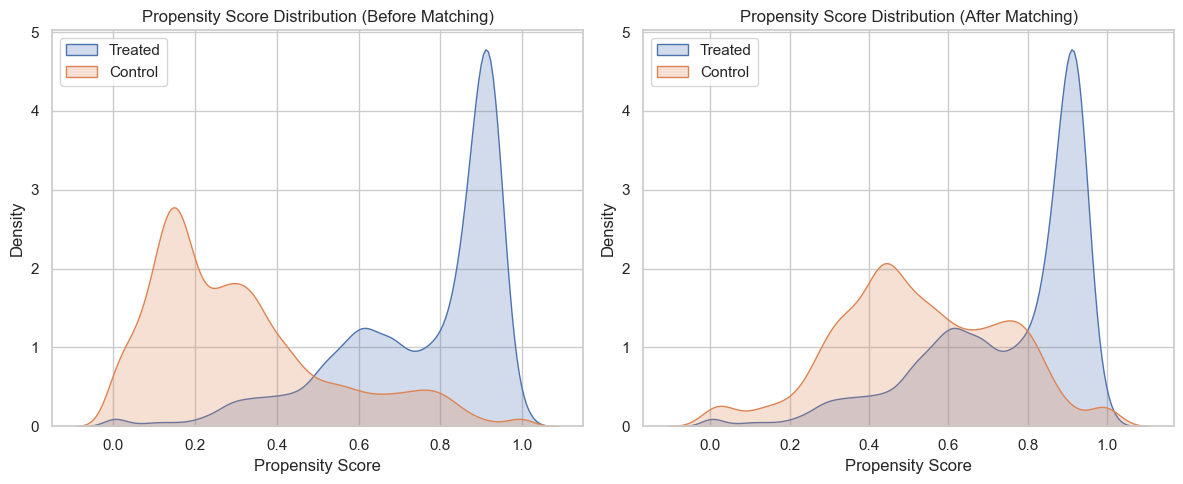

In [48]:
plt.figure(figsize=(12, 5))

# Before Matching
plt.subplot(1, 2, 1)
sns.kdeplot(df[df['housing_treatment'] == 1]['propensity_score'], label='Treated', fill=True)
sns.kdeplot(df[df['housing_treatment'] == 0]['propensity_score'], label='Control', fill=True)
plt.title('Propensity Score Distribution (Before Matching)')
plt.xlabel('Propensity Score')
plt.legend()

# After Matching
plt.subplot(1, 2, 2)
sns.kdeplot(matched_df_housing[matched_df_housing['housing_treatment'] == 1]['propensity_score'], label='Treated', fill=True)
sns.kdeplot(matched_df_housing[matched_df_housing['housing_treatment'] == 0]['propensity_score'], label='Control', fill=True)
plt.title('Propensity Score Distribution (After Matching)')
plt.xlabel('Propensity Score')
plt.legend()

plt.tight_layout()
plt.show()

# Loan

#### Mapping 'Yes' and 'No' to Numeric Values for Loan Treatment

Now, we are creating a new binary feature (`loan_treatment`) to represent whether a customer has a loan. We map 'yes' to 1 and 'no' to 0, which allows us to use it in our analysis.


In [49]:
df['loan_treatment'] = df['loan'].map({'yes': 1, 'no': 0}) 

#### Preparing the data for propensity score estimation for loan treatment

We prepare the dataset again, this time to estimate the propensity scores for loan treatment. We drop the target variable `y`, the `loan` variable, and the `loan_treatment` variable for this step.


In [50]:
X = df.drop(columns=['y', 'loan', 'loan_treatment'])  # drop target and loan_treatment
y = df['loan_treatment']

In [51]:
X = pd.get_dummies(X, drop_first=True)

#### Standardizing the features for loan treatment

We standardize the features for loan treatment to ensure they are on the same scale. This allows the model to treat each feature equally and improves performance.


In [52]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### Training a logistic regression model for loan propensity scores

We train a logistic regression model to estimate the propensity scores for loan treatment, using the same approach as before. These scores will be used for matching treated and control samples.


In [53]:
logreg = LogisticRegression(solver='saga', max_iter=1000)
logreg.fit(X_scaled, y)
df['propensity_score'] = logreg.predict_proba(X_scaled)[:, 1]

In [54]:
def match_sample(df, caliper=0.05):
    treated = df[df['loan_treatment'] == 1]
    control = df[df['loan_treatment'] == 0]
    matched_control = []

    for _, row in treated.iterrows():
        potential_matches = control[abs(control['propensity_score'] - row['propensity_score']) <= caliper]
        if not potential_matches.empty:
            match = potential_matches.sample(random_state=42)
            matched_control.append(match)
            control = control.drop(match.index)

    matched_control = pd.concat(matched_control)
    return pd.concat([treated, matched_control])

#### Performing Propensity Score Matching for Loan Treatment

We apply the same matching procedure as for housing treatment, but this time we match treated and control samples based on their propensity scores for loan treatment. The matched dataset helps us to compare the outcomes of those with loans to those without loans in a balanced way.


In [55]:
matched_df_loan = match_sample(df.copy())
matched_df_loan['y_numeric'] = matched_df_loan['y'].map({'yes': 1, 'no': 0})

att_loan = matched_df_loan[matched_df_loan['loan_treatment'] == 1]['y_numeric'].mean() - \
           matched_df_loan[matched_df_loan['loan_treatment'] == 0]['y_numeric'].mean()

print(f"ATT for Loan Treatment: {att_loan:.4f}")

ATT for Loan Treatment: -0.0266


#### Visualizing the propensity score distribution before and after matching for loan treatment

We again visualize the propensity score distributions for both treated and control groups based on loan treatment, before and after matching. This allows us to evaluate how well the matching procedure has worked.


/var/folders/l4/t9jrg3810fj7mltqzxyw19sh0000gn/T/ipykernel_45269/2075176851.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['loan_treatment'] == 1]['propensity_score'], label='Treated', shade=True)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/l4/t9jrg3810fj7mltqzxyw19sh0000gn/T/ipykernel_45269/2075176851.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['loan_treatment'] == 0]['propensity_score'], label='Control', shade=True)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119:

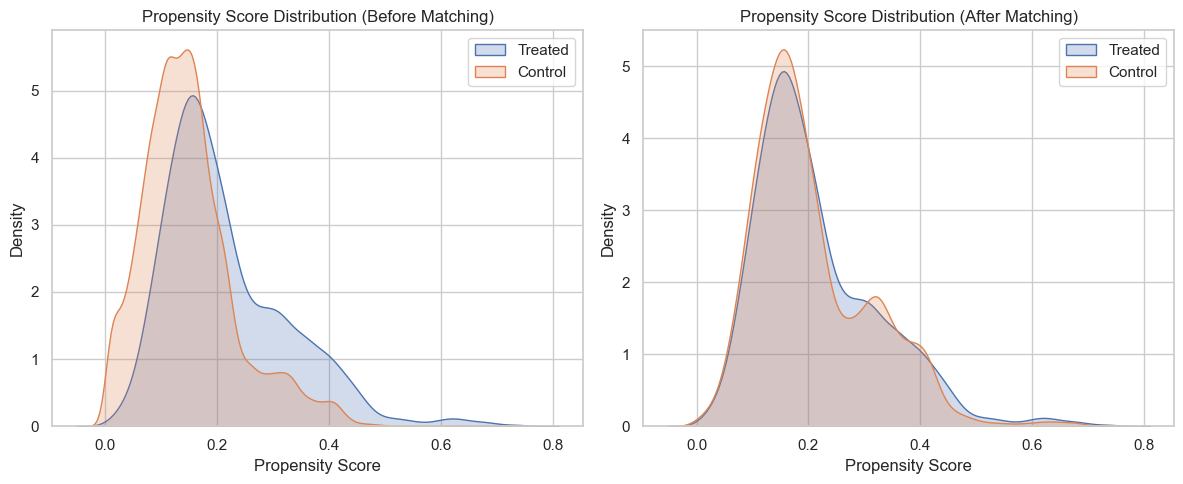

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

# Before Matching
plt.subplot(1, 2, 1)
sns.kdeplot(df[df['loan_treatment'] == 1]['propensity_score'], label='Treated', shade=True)
sns.kdeplot(df[df['loan_treatment'] == 0]['propensity_score'], label='Control', shade=True)
plt.title('Propensity Score Distribution (Before Matching)')
plt.xlabel('Propensity Score')
plt.legend()

# After Matching
plt.subplot(1, 2, 2)
sns.kdeplot(matched_df_loan[matched_df_loan['loan_treatment'] == 1]['propensity_score'], label='Treated', shade=True)
sns.kdeplot(matched_df_loan[matched_df_loan['loan_treatment'] == 0]['propensity_score'], label='Control', shade=True)
plt.title('Propensity Score Distribution (After Matching)')
plt.xlabel('Propensity Score')
plt.legend()

plt.tight_layout()
plt.show()


#### Performing an independent t-test to compare treated and control groups for loan treatment

We perform an independent t-test to compare the outcomes of the treated and control groups for loan treatment. This helps us determine if there is a statistically significant difference between the two groups, allowing us to evaluate the effect of loan treatment on the outcome.


In [57]:
from scipy.stats import ttest_ind

# Ensure outcome is numeric
matched_df_loan['y_numeric'] = matched_df_loan['y'].map({'yes': 1, 'no': 0})

# Split treated and control groups
treated_outcomes = matched_df_loan[matched_df_loan['loan_treatment'] == 1]['y_numeric']
control_outcomes = matched_df_loan[matched_df_loan['loan_treatment'] == 0]['y_numeric']

# Perform independent t-test
t_stat, p_val = ttest_ind(treated_outcomes, control_outcomes)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4f}")


T-statistic: -5.9006
P-value: 0.0000


# Final Remarks

This concludes the analysis of the impact of housing and loan treatments using propensity score matching. We performed matching, visualized the distributions, and assessed treatment effects using statistical tests. These methods help us understand the causal relationships and the effects of various treatments on the outcome.
